In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [77]:
pd.set_option('display.max_colwidth', None)

# Przygotowanie danych

In [78]:
data_path = "../../data/4_tanks/data/"

In [79]:
# # dane bez zakłóceń
# df_train = pd.read_csv(data_path+"result_ol_without_noise2.csv", sep=';', index_col=0)
# df_val_test = pd.read_csv(data_path+"result_ol_without_noise_val_test.csv", sep=';', index_col=0)
# dataset_name = "bez zakłóceń"

In [80]:
# dane z zakłóceniami
df_train = pd.read_csv(data_path+"result_ol_with_noise2.csv", sep=';', index_col=0)
df_val_test = pd.read_csv(data_path+"result_ol_with_noise_val_test.csv", sep=';', index_col=0)
dataset_name = "z zakłóceniami"

In [81]:
df_train.head()

,q_A [cm^3/s],q_B [cm^3/s],q_d1 [cm^3/s],q_d2 [cm^3/s],q_d3 [cm^3/s],q_d4 [cm^3/s],x1 [cm],x2 [cm],x3 [cm],x4 [cm]
0,452.78,555.56,0.1764,0.1593,0.2043,0.1417,65.000000,66.000000,65.000000,66.000000
1,452.78,555.56,0.0400,0.0569,-0.0919,0.0444,65.160726,66.096604,65.242498,66.134339
2,452.78,555.56,0.0979,-0.0114,0.0115,-0.0077,65.185700,66.089563,65.178513,66.165997
3,452.78,555.56,0.2241,0.0252,-0.0137,-0.1092,65.264368,66.015972,65.220639,66.144288
4,452.78,555.56,0.1868,-0.1211,0.1366,-0.0437,65.466310,65.983159,65.235780,66.021947


In [82]:
def transform_column_name(df):
    df.columns = [col[0] for col in df.columns.str.split()]
    return df

In [83]:
df_train = transform_column_name(df_train)
df_val_test = transform_column_name(df_val_test)

In [84]:
qa_max = round(3260000/3600, 2)
qa_min=0
qb_max = round(4000000/3600)
qb_min=0
x_max = 136
x_min = 20

In [85]:
def min_max_scale(s, min_value, max_value):
    return (s-min_value)/(max_value - min_value)

In [86]:
def min_max_scale_df(df):
    df['q_A'] = min_max_scale(df['q_A'], qa_min, qa_max)
    df['q_B'] = min_max_scale(df['q_B'], qb_min, qb_max)
    df['x1'] = min_max_scale(df['x1'], x_min, x_max)
    df['x2'] = min_max_scale(df['x2'], x_min, x_max)
    df['x3'] = min_max_scale(df['x3'], x_min, x_max)
    df['x4'] = min_max_scale(df['x4'], x_min, x_max)
    return df

In [87]:
df_train = min_max_scale_df(df_train)
df_val_test = min_max_scale_df(df_val_test)

In [88]:
def add_delay(df, col):    
    df[col+'(k+1)'] = df[col].shift(-1)
    return df

In [89]:
cols_delay = ['x1', 'x2', 'x3', 'x4']
for col in cols_delay:
    df_train = add_delay(df_train, col)
    df_val_test = add_delay(df_val_test, col)

In [90]:
df_val = df_val_test.iloc[:len(df_val_test)//2]
df_test = df_val_test.iloc[len(df_val_test)//2:]

In [91]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

C:\Users\zgore\AppData\Local\Temp\ipykernel_21452\2113831770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.dropna(inplace=True)
C:\Users\zgore\AppData\Local\Temp\ipykernel_21452\2113831770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(inplace=True)


In [92]:
print(f"Wymiar danych uczących: {df_train.shape}")
print(f"Wymiar danych walidacyjnych: {df_val.shape}")
print(f"Wymiar danych testowych: {df_test.shape}")

Wymiar danych uczących: (2999, 14)
Wymiar danych walidacyjnych: (1000, 14)
Wymiar danych testowych: (999, 14)


# Regresja liniowa

In [93]:
model_type = "regresji liniowej"

In [94]:
y_names = ['x1(k+1)', 'x2(k+1)', 'x3(k+1)', 'x4(k+1)']

In [95]:
all_features = ['q_A', 'q_B', 'x1', 'x2', 'x3', 'x4']

In [96]:
models_results_df = pd.DataFrame(columns=["Zmienne wejściowe", "Zmienna wyjściowa", "Współczynniki modelu", "RMSE_ucz", "RMSE_wal", "RMSE_test"])
for y_name in y_names:
    features = [f for f in all_features if y_name[:2] not in f]
    model = LinearRegression()
    model.fit(df_train[features], df_train[y_name])

    df_train[f'{y_name}_pred'] = model.predict(df_train[features])
    df_train[f'{y_name}_pred'] = np.clip(df_train[f'{y_name}_pred'], 0, 1)    
    RMSE_train = round(metrics.root_mean_squared_error(df_train[y_name], df_train[f'{y_name}_pred']), 4)
    df_val[f'{y_name}_pred'] = model.predict(df_val[features])
    df_val[f'{y_name}_pred'] = np.clip(df_val[f'{y_name}_pred'], 0, 1)    
    RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[f'{y_name}_pred']), 4)
    df_val[f'{y_name}_pred'] = model.predict(df_val[features])
    df_val[f'{y_name}_pred'] = np.clip(df_val[f'{y_name}_pred'], 0, 1)    
    RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[f'{y_name}_pred']), 4)    
    df_test[f'{y_name}_pred'] = model.predict(df_test[features])
    df_test[f'{y_name}_pred'] = np.clip(df_test[f'{y_name}_pred'], 0, 1)    
    RMSE_test = round(metrics.root_mean_squared_error(df_test[y_name], df_test[f'{y_name}_pred']), 4)

    models_results_df.loc[len(models_results_df)] = [features, y_name, np.round(model.coef_, 3), RMSE_train, RMSE_val, RMSE_test]

C:\Users\zgore\AppData\Local\Temp\ipykernel_21452\3719026364.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[f'{y_name}_pred'] = model.predict(df_val[features])
C:\Users\zgore\AppData\Local\Temp\ipykernel_21452\3719026364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[f'{y_name}_pred'] = np.clip(df_val[f'{y_name}_pred'], 0, 1)
C:\Users\zgore\AppData\Local\Temp\ipykernel_21452\3719026364.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [97]:
models_results_df

,Zmienne wejściowe,Zmienna wyjściowa,Współczynniki modelu,RMSE_ucz,RMSE_wal,RMSE_test
0,"[q_A, q_B, x2, x3, x4]",x1(k+1),"[0.313, -0.312, 0.454, 0.545, -0.092]",0.0477,0.0537,0.0567
1,"[q_A, q_B, x1, x3, x4]",x2(k+1),"[-0.265, 0.67, 0.401, -0.029, 0.547]",0.0452,0.0481,0.0576
2,"[q_A, q_B, x1, x2, x4]",x3(k+1),"[-0.271, 0.467, 1.142, -0.11, -0.145]",0.0644,0.0222,0.0535
3,"[q_A, q_B, x1, x2, x3]",x4(k+1),"[0.628, -0.827, -0.187, 1.201, -0.168]",0.0664,0.1486,0.0815


In [105]:
models_results_df.index.name = 'l.p.'

In [107]:
print(models_results_df[['Zmienne wejściowe', 'Zmienna wyjściowa', 
       'RMSE_ucz', 'RMSE_wal', 'RMSE_test']].to_latex(float_format="%.4f", caption=f'Wyniki modelowania dla {model_type} dla danych {dataset_name}.', label=f'tab:res_{model_type}_{dataset_name}'))

\begin{table}
\caption{Wyniki modelowania dla regresji liniowej dla danych z zakłóceniami.}
\label{res_regresji liniowej_z zakłóceniami}
\begin{tabular}{lllrrr}
\toprule
 & Zmienne wejściowe & Zmienna wyjściowa & RMSE_ucz & RMSE_wal & RMSE_test \\
l.p. &  &  &  &  &  \\
\midrule
0 & ['q_A', 'q_B', 'x2', 'x3', 'x4'] & x1(k+1) & 0.0477 & 0.0537 & 0.0567 \\
1 & ['q_A', 'q_B', 'x1', 'x3', 'x4'] & x2(k+1) & 0.0452 & 0.0481 & 0.0576 \\
2 & ['q_A', 'q_B', 'x1', 'x2', 'x4'] & x3(k+1) & 0.0644 & 0.0222 & 0.0535 \\
3 & ['q_A', 'q_B', 'x1', 'x2', 'x3'] & x4(k+1) & 0.0664 & 0.1486 & 0.0815 \\
\bottomrule
\end{tabular}
\end{table}



In [100]:
def plot_model_result(df, y_name):
    plt.grid()
    plt.plot(df[f'{y_name}_pred'], label='Przewidywany', linewidth=3)
    plt.plot(df[y_name], label='Rzeczywisty', linewidth=1.5, c="tab:orange")
    plt.xlabel('Czas [s]')
    plt.ylabel('Poziom cieczy')
    plt.title(f"Poziom cieczy w {y_name[1]}. zbiorniku")
    plt.legend()

In [101]:
def plot_model_result_all_tanks(df, model_type, dataset_name, data_name):
    fig=plt.figure(figsize=(8,11.5))
    plt.subplot(4, 1, 1)
    plot_model_result(df, 'x1(k+1)')
    plt.subplot(4, 1, 2)
    plot_model_result(df, 'x2(k+1)')
    plt.subplot(4, 1, 3)
    plot_model_result(df, 'x3(k+1)')
    plt.subplot(4, 1, 4)
    plot_model_result(df, 'x4(k+1)')

    plt.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"Wyniki {model_type} dla danych {data_name} {dataset_name}")

    plt.savefig(f"../img/result_ol_{model_type}_{data_name}_{dataset_name}.png", bbox_inches='tight')

    plt.show()

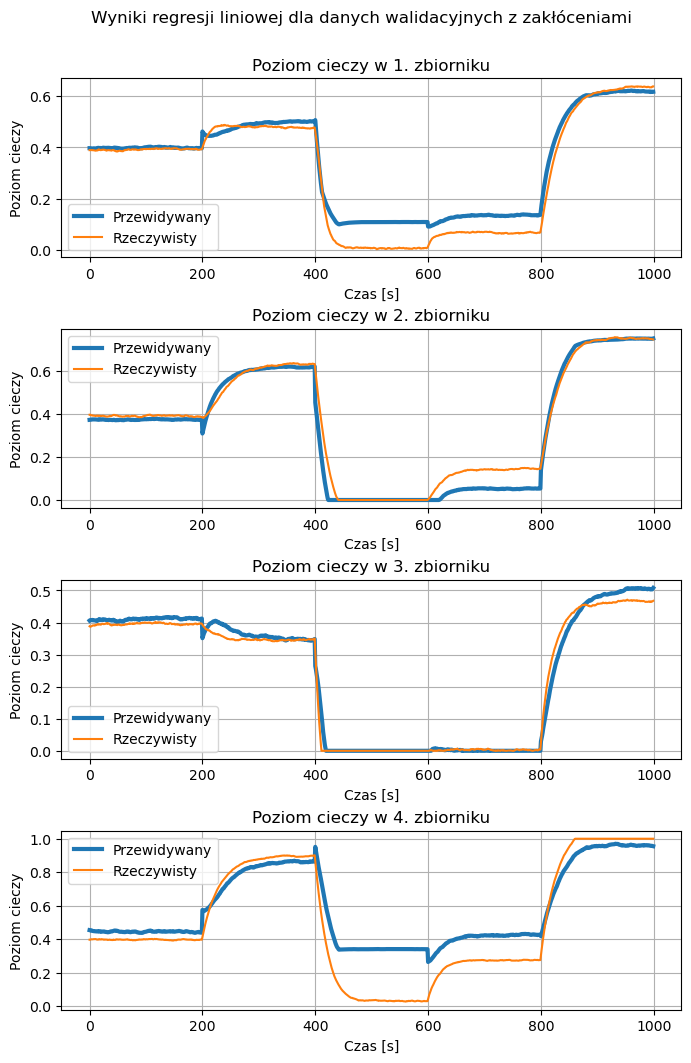

In [102]:
plot_model_result_all_tanks(df_val, model_type, dataset_name, "walidacyjnych")

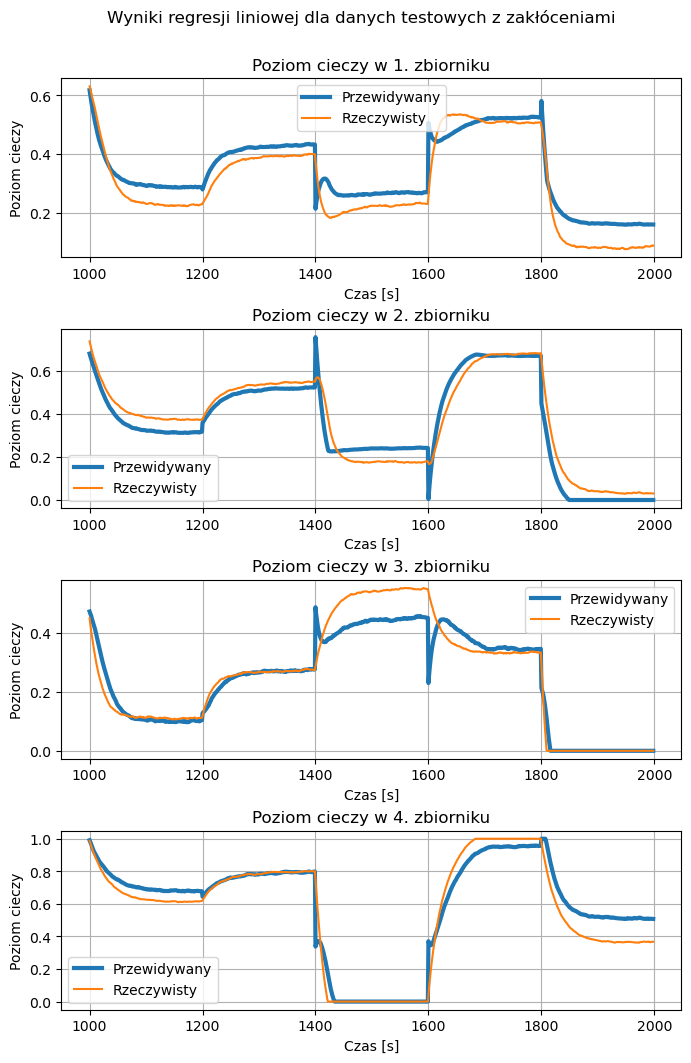

In [103]:
plot_model_result_all_tanks(df_test, model_type, dataset_name, "testowych")